In [3]:
# Import packages

import pandas as pd

import numpy as np
import _pickle as cpickle

import sys
sys.path.insert(0, '/home/ec2-user/SageMaker/mymodule/')
from common_functions import psi
from common_functions import ks
from common_functions import data_vars

from impute_functions import setMax


import matplotlib.pyplot as plt

%matplotlib inline
import boto3
#!pip install graphviz
# !pip install scipy

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [4]:
bucket_name = 'mf-ml-ds'
s3_source = 's3://'+ bucket_name +'/Grid3'
s3_source_path  = s3_source 

In [5]:
df=pd.read_csv(s3_source_path + '/grid3_dev.csv')



In [6]:
df.shape

(209981, 1372)

In [7]:
df=df.drop(['Point_in_time'],axis=1)

In [8]:
ptable = pd.DataFrame()
for col in df.columns:
    percentiles = df[col].quantile([0.01,0.99]).values
    df.loc[df[col] <= percentiles[0], col] = percentiles[0]
    df.loc[df[col] >= percentiles[1], col] = percentiles[1]
    ptable[col]=percentiles

In [9]:
df['AMS3835'].fillna(1, inplace=True)


In [10]:
df=df.fillna(0)

In [11]:
#split the model development sample into train and test sample
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(df.drop(['final_bad_perf','VANTAGE4'], axis='columns'), df.final_bad_perf, test_size=0.3)

In [13]:
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
XGB=XGBClassifier(n_estimators=20, min_samples_leaf=5, class_weight="balanced_subsample", randomstate=42)



In [ ]:
sel_ = SelectFromModel(XGB, max_features=20)
sel_.fit(X_train, y_train)
selected_feat = X_train.columns[(sel_.get_support())]
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))

In [11]:
list(selected_feat)

['resi_num_years',
 'OE_Score',
 'FICO9',
 'Disposable_Income',
 'Verified_Income',
 'Total_Income',
 'Debt_Ratio',
 'AMS3746',
 'AMS3752',
 'TDA02615',
 'HO',
 'secure',
 'singleborrower']

In [12]:
X_train2=X_train[['resi_num_years',
 'OE_Score',
 'FICO9',
 'Disposable_Income',
 'Verified_Income',
 'Total_Income',
 'Debt_Ratio',
 'AMS3746',
 'AMS3752',
 'TDA02615',
 'HO',
 'secure',
 'singleborrower']]
X_test2=X_test[['resi_num_years',
 'OE_Score',
 'FICO9',
 'Disposable_Income',
 'Verified_Income',
 'Total_Income',
 'Debt_Ratio',
 'AMS3746',
 'AMS3752',
 'TDA02615',
 'HO',
 'secure',
 'singleborrower']]




In [13]:
#check VIF first X_train2 then change to X_train3 after dropping some variables
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
X=add_constant(X_train2)



pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index= X.columns)

const                113.259722
resi_num_years         1.343838
OE_Score               1.404237
FICO9                  1.281602
Disposable_Income      4.381014
Verified_Income        2.304306
Total_Income           3.368374
Debt_Ratio             1.106542
AMS3746                1.333802
AMS3752                1.320037
TDA02615               1.067869
HO                     1.294579
secure                 1.061347
singleborrower         1.096438
dtype: float64

In [14]:
XGB.fit(X_train2, y_train)

XGB.score(X_test2,y_test)

0.8096515596475911

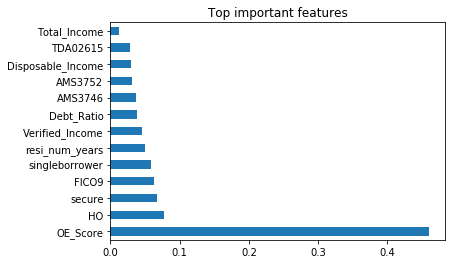

In [15]:
feat_importances=pd.Series(XGB.feature_importances_, index=X_train2.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.title('Top important features')
plt.show()

In [14]:

X_train_baseline=X_train[['OE_Score','FICO9']]
X_test_baseline=X_test[['OE_Score','FICO9']]
XGB.fit(X_train_baseline, y_train)
pred=XGB.predict_proba(X_test_baseline)[:, 1]


In [83]:
def ks_20(data=None,target=None, prob=None):

    data['target0'] = 1 - data[target]

    data['bucket'] = pd.qcut(data[prob], 20)

    grouped = data.groupby('bucket', as_index = False)

    kstable = pd.DataFrame()

    kstable['min_score'] = grouped.min()[prob]

    kstable['max_score'] = grouped.max()[prob]

    kstable['events']   = grouped.sum()[target]

    kstable['nonevents'] = grouped.sum()['target0']
    
    kstable = kstable.sort_values(by="min_score", ascending=False).reset_index(drop = True)
    
#     kstable['cumevents']=  kstable.events.cumsum()
#     kstable['cumnonevents']= kstable.nonevents.cumsum()
#     kstable['totevents']= kstable.events.sum()

    kstable['total']= kstable.events+kstable.nonevents
    
    kstable['event_rate']= (kstable.events/kstable.total).apply('{:.2%}'.format)
    kstable['nonevent_rate']= (kstable.nonevents/kstable.total).apply('{:.2%}'.format)
    
    kstable['% events'] = (kstable.events / kstable.events.sum()).apply('{:.2%}'.format)

    kstable['% nonevents'] = (kstable.nonevents / kstable.nonevents.sum()).apply('{:.2%}'.format)

    
    kstable['% cum_events']= (kstable.events / kstable.events.sum()).cumsum()

    kstable['% cum_nonevents']= (kstable.nonevents / kstable.nonevents.sum()).cumsum()
    
    
    kstable['KS'] = np.round(kstable['% cum_events']-kstable['% cum_nonevents'], 3) * 100
    
    kstable['KS']=np.abs(kstable['KS'])

    #Formating

    kstable['% cum_events']= kstable['% cum_events'].apply('{:.2%}'.format)

    kstable['% cum_nonevents']= kstable['% cum_nonevents'].apply('{:.2%}'.format)

    kstable.index = range(1,21)

    kstable.index.rename('Decile', inplace=True)

    pd.set_option('display.max_columns', None)
    
    #last entry
    events=sum(kstable["events"])
    nonevents=sum(kstable["nonevents"])
    grandtot=sum(kstable["total"])
    event_rate="{:.2%}".format(events/grandtot)
    nonevent_rate="{:.2%}".format(nonevents/grandtot)
    percent_event="{:.2%}".format(1)
    percent_nonevent="{:.2%}".format(1)
    
    finalks=max(kstable['KS'])
    lastentry = {'events': events, 'nonevents': nonevents, 'total': grandtot, 'event_rate': event_rate, 
                 'nonevent_rate':nonevent_rate, '% events': percent_event, '% nonevents': percent_nonevent,  'KS': finalks}
    
    kstable = kstable.append(lastentry, ignore_index=True)

    kstable.replace(np.NaN, ' ', inplace=True)
    print(kstable)

    #Display KS

    from colorama import Fore

    print(Fore.RED + "KS is " + str(max(kstable['KS']))+"%"+ " at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))

    return(kstable)

In [81]:
# from common_functions import ks
import pandas as pd

#merge only the test dataset
y_test_hat=pred

#convert ndarray to a dataframe, so that it can merge with true y in the merge statement

y_test_hat_df=pd.DataFrame(data=y_test_hat, columns=['Y_hats'], index=X_test_baseline.index.copy())

df_out=pd.merge(y_test, y_test_hat_df, how='left', left_index=True, right_index=True)
ks_test=ks(data=df_out, target='final_bad_perf', prob='Y_hats')

   min_score max_score   events  nonevents    total event_rate nonevent_rate  \
0   0.384821   0.54248   2747.0     3330.0   6077.0     45.20%        54.80%   
1   0.302533  0.379684   2104.0     4221.0   6325.0     33.26%        66.74%   
2   0.260518  0.302406   1628.0     4802.0   6430.0     25.32%        74.68%   
3   0.223547  0.260221   1313.0     4896.0   6209.0     21.15%        78.85%   
4   0.199969  0.222205   1089.0     5175.0   6264.0     17.39%        82.61%   
5   0.181174  0.199263    708.0     4017.0   4725.0     14.98%        85.02%   
6   0.164897  0.181158    964.0     6315.0   7279.0     13.24%        86.76%   
7   0.147781  0.164787    678.0     5526.0   6204.0     10.93%        89.07%   
8   0.132395  0.147688    595.0     5894.0   6489.0      9.17%        90.83%   
9   0.107753  0.131828    417.0     6576.0   6993.0      5.96%        94.04%   
10                      12243.0    50752.0  62995.0     19.43%        80.57%   

   % events % nonevents % cum_events % 

In [84]:
ks_test=ks_20(data=df_out, target='final_bad_perf', prob='Y_hats')

   min_score max_score   events  nonevents    total event_rate nonevent_rate  \
0   0.442692   0.54248   1567.0     1483.0   3050.0     51.38%        48.62%   
1   0.384821  0.438336   1180.0     1847.0   3027.0     38.98%        61.02%   
2   0.336009  0.379684   1179.0     2190.0   3369.0     35.00%        65.00%   
3   0.302533  0.335306    925.0     2031.0   2956.0     31.29%        68.71%   
4   0.289837  0.302406    772.0     2107.0   2879.0     26.81%        73.19%   
5   0.260518  0.289764    856.0     2695.0   3551.0     24.11%        75.89%   
6   0.242669  0.260221    720.0     2489.0   3209.0     22.44%        77.56%   
7   0.223547  0.241556    593.0     2407.0   3000.0     19.77%        80.23%   
8   0.212778  0.222205    560.0     2423.0   2983.0     18.77%        81.23%   
9   0.199969  0.210651    529.0     2752.0   3281.0     16.12%        83.88%   
10  0.192107  0.199263    498.0     2797.0   3295.0     15.11%        84.89%   
11  0.181174  0.190331    210.0     1220

In [16]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, pred)
# metrics.plot_roc_curve(XGB, X_test_baseline, y_test)  
# plt.show()  

0.7036367014474911

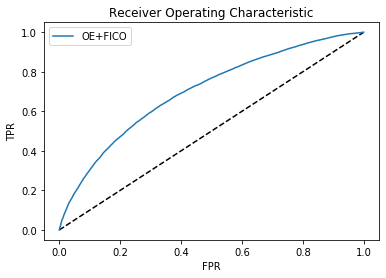

In [19]:
# X_train_incremental=X_train[['OE_Score','FICO9','secure', 'resi_num_years', 'singleborrower']]
# X_test_incremental=X_test[['OE_Score','FICO9','secure','resi_num_years', 'singleborrower']]

X_train_incremental1=X_train[['OE_Score','FICO9','secure']]
X_test_incremental1=X_test[['OE_Score','FICO9','secure']]
XGB.fit(X_train_incremental1, y_train)
pred2=XGB.predict_proba(X_test_incremental1)[:, 1]
roc_auc_score(y_test, pred2)


X_train_incremental2=X_train[['OE_Score','FICO9','HO']]
X_test_incremental2=X_test[['OE_Score','FICO9','HO']]
XGB.fit(X_train_incremental2, y_train)
pred3=XGB.predict_proba(X_test_incremental2)[:, 1]
roc_auc_score(y_test, pred3)

X_train_incremental3=X_train[['OE_Score','FICO9','NB']]
X_test_incremental3=X_test[['OE_Score','FICO9','NB']]
XGB.fit(X_train_incremental3, y_train)
pred4=XGB.predict_proba(X_test_incremental3)[:, 1]
roc_auc_score(y_test, pred4)

X_train_incremental4=X_train[['OE_Score','FICO9', 'secure','NB']]
X_test_incremental4=X_test[['OE_Score','FICO9','secure','NB']]
XGB.fit(X_train_incremental4, y_train)
pred5=XGB.predict_proba(X_test_incremental4)[:, 1]
roc_auc_score(y_test, pred5)

X_train_incremental5=X_train[['OE_Score','FICO9', 'secure','NB','HO']]
X_test_incremental5=X_test[['OE_Score','FICO9','secure','NB','HO']]
XGB.fit(X_train_incremental5, y_train)
pred6=XGB.predict_proba(X_test_incremental5)[:, 1]
roc_auc_score(y_test, pred6)

X_train_incremental6=X_train[['Online_Custom_ScoreOld','FICO9', 'secure','NB','HO']]
X_test_incremental6=X_test[['Online_Custom_ScoreOld','FICO9','secure','NB','HO']]
XGB.fit(X_train_incremental6, y_train)
pred7=XGB.predict_proba(X_test_incremental6)[:, 1]
roc_auc_score(y_test, pred7)


0.6919125241488606

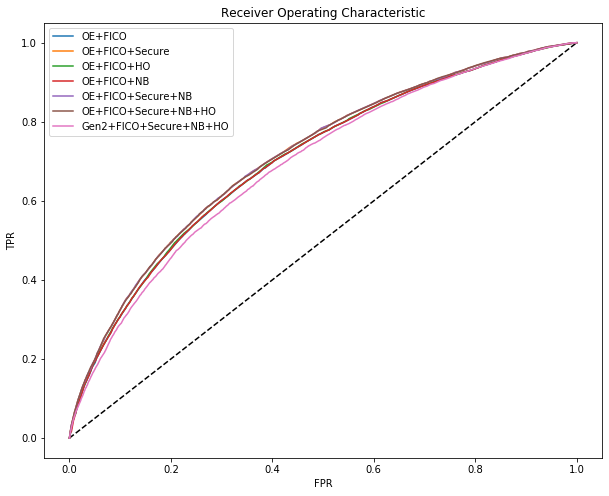

In [21]:

from sklearn.metrics import roc_curve


fpr1 , tpr1, thresholds1 = roc_curve(y_test, pred)


fpr2 , tpr2, thresholds2 = roc_curve(y_test, pred2)



fpr3 , tpr3, thresholds3 = roc_curve(y_test, pred3)


fpr4 , tpr4, thresholds4 = roc_curve(y_test, pred4)

fpr5 , tpr5, thresholds5 = roc_curve(y_test, pred5)
fpr6 , tpr6, thresholds6 = roc_curve(y_test, pred6)
fpr7 , tpr7, thresholds7 = roc_curve(y_test, pred7)

plt.figure(figsize=(10, 8))
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "OE+FICO")
plt.plot(fpr2, tpr2, label= "OE+FICO+Secure")
plt.plot(fpr3, tpr3, label= "OE+FICO+HO")
plt.plot(fpr4, tpr4, label= "OE+FICO+NB")
plt.plot(fpr5, tpr5, label= "OE+FICO+Secure+NB")
plt.plot(fpr6, tpr6, label= "OE+FICO+Secure+NB+HO")
plt.plot(fpr7, tpr7, label= "Gen2+FICO+Secure+NB+HO")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')
plt.show()

In [24]:
def largest_within_delta(X, k):
    right_idx = X.searchsorted(k,'right')-1
    if (X[right_idx]) <= k:
        return right_idx

    else:
        return None
    
    print(right_idx)

fpr11=fpr1[:largest_within_delta(fpr1, 0.1)]
fpr21=fpr2[:largest_within_delta(fpr2, 0.1)]
fpr31=fpr3[:largest_within_delta(fpr3, 0.1)]
fpr41=fpr4[:largest_within_delta(fpr4, 0.1)]
fpr51=fpr5[:largest_within_delta(fpr5, 0.1)]
fpr61=fpr6[:largest_within_delta(fpr6, 0.1)]
fpr71=fpr7[:largest_within_delta(fpr7, 0.1)]
tpr11=tpr1[:largest_within_delta(fpr1, 0.1)]
tpr21=tpr2[:largest_within_delta(fpr2, 0.1)]
tpr31=tpr3[:largest_within_delta(fpr3, 0.1)]
tpr41=tpr4[:largest_within_delta(fpr4, 0.1)]
tpr51=tpr5[:largest_within_delta(fpr5, 0.1)]
tpr61=tpr6[:largest_within_delta(fpr6, 0.1)]
tpr71=tpr7[:largest_within_delta(fpr7, 0.1)]


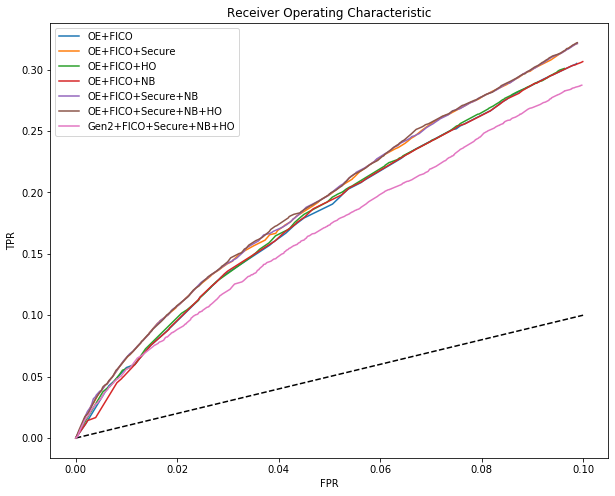

In [25]:
plt.figure(figsize=(10, 8))
plt.plot([0,0.1],[0,0.1], 'k--')
plt.plot(fpr11, tpr11, label= "OE+FICO")
plt.plot(fpr21, tpr21, label= "OE+FICO+Secure")
plt.plot(fpr31, tpr31, label= "OE+FICO+HO")
plt.plot(fpr41, tpr41, label= "OE+FICO+NB")
plt.plot(fpr51, tpr51, label= "OE+FICO+Secure+NB")
plt.plot(fpr61, tpr61, label= "OE+FICO+Secure+NB+HO")
plt.plot(fpr71, tpr71, label= "Gen2+FICO+Secure+NB+HO")

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')
plt.show()


In [95]:
# from common_functions import ks
import pandas as pd

#merge only the test dataset
y_test_hat=pred


#convert ndarray to a dataframe, so that it can merge with true y in the merge statement

y_test_hat_df=pd.DataFrame(data=y_test_hat, columns=['Y_hats'], index=X_test_baseline.index.copy())

df_out=pd.merge(y_test, y_test_hat_df, how='left', left_index=True, right_index=True)
ks_test=ks_20(data=df_out, target='final_bad_perf', prob='Y_hats')

   min_score max_score   events  nonevents    total event_rate nonevent_rate  \
0   0.441858     0.551   1666.0     1477.0   3143.0     53.01%        46.99%   
1   0.380556  0.441621   1292.0     1838.0   3130.0     41.28%        58.72%   
2   0.337572  0.380347   1133.0     2016.0   3149.0     35.98%        64.02%   
3   0.314348  0.336932    923.0     2225.0   3148.0     29.32%        70.68%   
4   0.289198  0.314325    870.0     2271.0   3141.0     27.70%        72.30%   
5   0.259798  0.289104    726.0     2401.0   3127.0     23.22%        76.78%   
6   0.242586  0.259188    702.0     2507.0   3209.0     21.88%        78.12%   
7   0.227479  0.242491    636.0     2515.0   3151.0     20.18%        79.82%   
8   0.215268  0.227022    538.0     2607.0   3145.0     17.11%        82.89%   
9   0.198831  0.215245    483.0     2449.0   2932.0     16.47%        83.53%   
10  0.189878   0.19873    522.0     2842.0   3364.0     15.52%        84.48%   
11  0.177752  0.189439    350.0     2127

In [78]:
ks_test.to_excel('grid3_ks.xlsx')

In [158]:
df_oot=pd.read_csv(s3_source_path + '/grid3_oot.csv')
df_oot.shape

(147922, 1371)

In [45]:

X_oot=df_oot[['resi_num_years',
 'OE_Score',
 'FICO9',
 'Disposable_Income',
 'Verified_Income',
 'Total_Income',
 'Debt_Ratio',
 'AMS3746',
 'AMS3752',
 'TDA02615',
 'HO',
 'secure',
 'singleborrower']]

In [46]:
for col in X_oot.columns:

    p1 = ptable[col].min()
    p99= ptable[col].max()
    X_oot.loc[X_oot[col] <= p1, col] = p1
    X_oot.loc[X_oot[col] >= p99, col] = p99

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [47]:

X_oot_incremental=X_oot[['OE_Score','FICO9','secure',  'resi_num_years', 'singleborrower']]
y_oot=df_oot.final_bad_perf

XGB.score(X_oot_incremental,y_oot)

pred=XGB.predict_proba(X_oot_incremental)[:, 1]

In [48]:
y_test_hat=pred

#convert ndarray to a dataframe, so that it can merge with true y in the merge statement

y_test_hat_df=pd.DataFrame(data=y_test_hat, columns=['Y_hats'], index=X_oot_incremental.index.copy())

df_out=pd.merge(y_oot, y_test_hat_df, how='left', left_index=True, right_index=True)
ks_test=ks(data=df_out, target='final_bad_perf', prob='Y_hats')

   min_score max_score  events  nonevents   total event_rate nonevent_rate  \
0   0.369661  0.548873    5576       9178   14754     37.79%        62.21%   
1   0.308652  0.369082    3720      11088   14808     25.12%        74.88%   
2   0.253959  0.308574    2887      11821   14708     19.63%        80.37%   
3   0.224086  0.253851    2312      12543   14855     15.56%        84.44%   
4   0.199919  0.224038    1812      11802   13614     13.31%        86.69%   
5   0.173849  0.199864    1682      14042   15724     10.70%        89.30%   
6   0.158175  0.173637    1348      13621   14969      9.01%        90.99%   
7     0.1459  0.158116    1021      13516   14537      7.02%        92.98%   
8    0.13237  0.145894     843      14116   14959      5.64%        94.36%   
9   0.106047   0.13229     534      14460   14994      3.56%        96.44%   
10                       21735     126187  147922     14.69%        85.31%   

   % events % nonevents % cum_events % cum_nonevents    KS  
0 

In [50]:
df2=df[['final_bad_perf','OE_Score','FICO9','secure', 'resi_num_years','singleborrower', 'Debt_Ratio','Verified_Income']]

In [51]:
import scorecardpy as sc
bins=sc.woebin(df2, y="final_bad_perf", save_breaks_list='breaks_list')


[INFO] creating woe binning ...
[INFO] The breaks_list is saved as breaks_list_20210706_203238.py


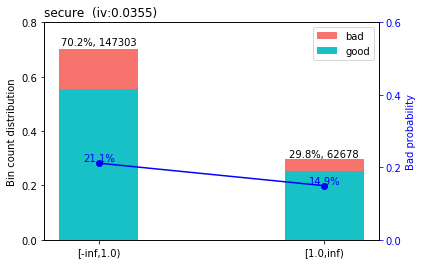

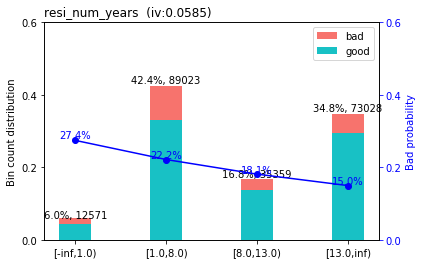

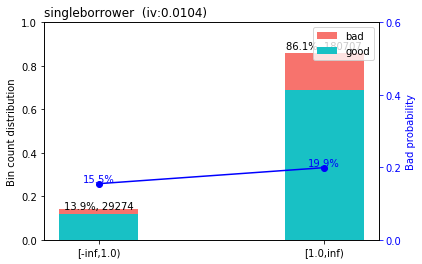

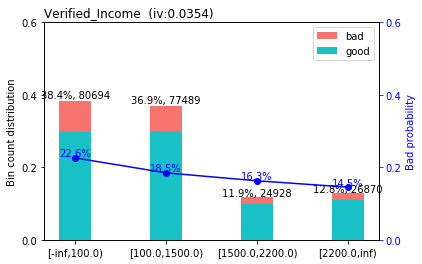

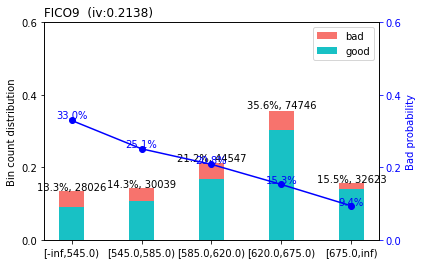

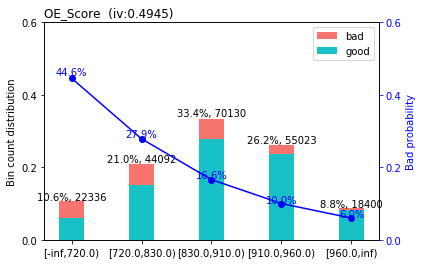

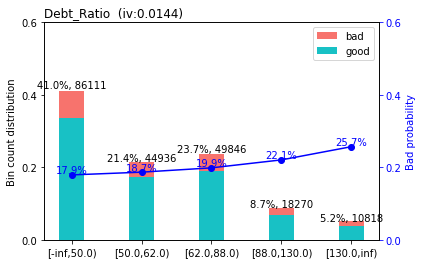

In [52]:
plotlist=sc.woebin_plot(bins)